In [196]:
#!/usr/bin/env python
# Shiman Ding 

"""
AY 250 - Scientific Research Computing with Python
Homework Assignment 4 - Parallel Feature Extraction Example
Author: Christopher Klein, Joshua Bloom
"""
import os
from os import listdir
from multiprocessing import Pool, cpu_count
from pylab import imread
from time import time

In [246]:
from skimage import data, io, filters, transform
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
%pylab inline

import numpy as np
import pandas as pd
import scipy as sp

from glob import glob

# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

Populating the interactive namespace from numpy and matplotlib


In [5]:
!pwd

/Users/shiman/Dropbox/student seminar/Python_For_Data_Science/Shiman/HW4


In [6]:
!ls

50_categories
Untitled.ipynb
hw_4-machine-learning-parallel-strawman.py
hw_4-machine-learning.pdf


In [90]:
def load_image(img_path, n=300):
    
    # load the image from file
    img = skimage.io.imread(img_path).astype('f8')
    # make sure it has three channels
    if img.ndim == 2:
        img = img[:, :, None] * np.ones(img.shape + (3,))

    # equalize histograms
    img = skimage.exposure.equalize_hist(img)
    # reduce noise
    img = skimage.restoration.denoise_bilateral(img, 3, 0.1)

    # scale largest dimension to be of size n
    shape = img.shape[:2]
    scale = float(n) / max(shape)
    img = skimage.transform.rescale(img, scale)
    shape = img.shape[:2]

    return img



In [3]:
# Quick function to divide up a large list into multiple small lists, 
# attempting to keep them all the same size. 
def split_seq(seq, size):
        newseq = []
        splitsize = 1.0/size*len(seq)
        for i in range(size):
            newseq.append(seq[int(round(i*splitsize)):
                int(round((i+1)*splitsize))])
        return newseq

In [284]:
# Our simple feature extraction function. It takes in a list of image paths, 
# does some measurement on each image, then returns a list of the image paths
# paired with the results of the feature measurement.
def extract_features(image_path_list):
    features = np.array([])
    for image_path in image_path_list:
        print(image_path)
        image_array = load_image(image_path)
        RGB = image_array.reshape((size(image_array)/3, 3)).T
        grey = rgb2gray(image_array)
        
        mean = RGB.mean(axis = 1)
        median = np.median(RGB, axis = 1)
        rgb_cov = np.cov(RGB).ravel()
        grey_mean = grey.mean()
        grey_median = np.median(grey)
        grey_cov = np.var(grey).ravel()
        feature = np.concatenate([mean, median, rgb_cov, [grey_mean, grey_median, grey_cov]])
        if len(features) == 0:
            features = feature
        else:
            features = vstack((features, feature))
    return features

In [285]:
### Main program starts here ###################################################
# We first collect all the local paths to all the images in one list
MYDIRECTORY = "/Users/shiman/Dropbox/student seminar/Python_For_Data_Science/Shiman/HW4/50_categories"
image_paths = []
categories = listdir(MYDIRECTORY)
categories = categories[2:]
for category in categories:
    image_names = listdir(MYDIRECTORY  + "/" + category)

image_paths = glob("./50_categories/*/*.jpg")
print ("There should be 4244 images, actual number is " + 
    str(len(image_paths)) + ".")

# Then, we run the feature extraction function using multiprocessing.Pool so 
# so that we can parallelize the process and run it much faster.
numprocessors = cpu_count() # To see results of parallelizing, set numprocessors
                            # to less than cpu_count().
# numprocessors = 1

# We have to cut up the image_paths list into the number of processes we want to
# run. 
split_image_paths = split_seq(image_paths, numprocessors)

# Ok, this block is where the parallel code runs. We time it so we can get a 
# feel for the speed up.
start_time = time()
p = Pool(numprocessors)
result = p.map_async(extract_features, split_image_paths)
poolresult = result.get()
end_time = time()

# All done, print timing results.
print ("Finished extracting features. Total time: " + 
    str(round(end_time-start_time, 3)) + " s, or " + 
    str( round( (end_time-start_time)/len(image_paths), 5 ) ) + " s/image.")
# This took about 10-11 seconds on my 2.2 GHz, Core i7 MacBook Pro. It may also
# be affected by hard disk read speeds.

# To tidy-up a bit, we loop through the poolresult to create a final list of
# the feature extraction results for all images.
combined_result = []
for single_proc_result in poolresult:
    for single_image_result in single_proc_result:
        combined_result.append(single_image_result)



There should be 4244 images, actual number is 4244.
./50_categories/crab/crab_0039.jpg
./50_categories/airplanes/airplanes_0001.jpg
./50_categories/horse/horse_0095.jpg
./50_categories/owl/owl_0080.jpg
./50_categories/crab/crab_0040.jpg
./50_categories/airplanes/airplanes_0002.jpg
./50_categories/crab/crab_0041.jpg
./50_categories/airplanes/airplanes_0003.jpg
./50_categories/airplanes/airplanes_0004.jpg
./50_categories/crab/crab_0042.jpg
./50_categories/horse/horse_0096.jpg
./50_categories/airplanes/airplanes_0005.jpg
./50_categories/crab/crab_0043.jpg
./50_categories/penguin/penguin_0001.jpg
./50_categories/airplanes/airplanes_0006.jpg
./50_categories/crab/crab_0044.jpg
./50_categories/airplanes/airplanes_0007.jpg
./50_categories/horse/horse_0097.jpg
./50_categories/crab/crab_0045.jpg
./50_categories/airplanes/airplanes_0008.jpg
./50_categories/horse/horse_0098.jpg
./50_categories/crab/crab_0046.jpg
./50_categories/airplanes/airplanes_0009.jpg
./50_categories/crab/crab_0047.jpg
./50_c

In [198]:
def get_image_categories(images):
    
    get_category = lambda x: os.path.split(os.path.split(x)[0])[1]
    categories = list(map(get_category, images))
    category_map = sorted(set(categories))
    categories = np.array(map(category_map.index, categories))
    return categories, category_map



In [286]:
categories, catogory_map = get_image_categories(image_paths)

In [287]:
# features and categories
data = np.concatenate([combined_result, np.array(categories).reshape((4244,1))], axis = 1)

In [288]:
# save to disk
filename = "./image_dataset.npy"
np.save(filename, data)
print("Saved features to '%s'" % filename)

filename = "./image_categories.npy"
np.save(filename, category_map)
print("Saved categories to '%s'" % filename)

Saved features to './image_dataset.npy'
Saved categories to './image_categories.npy'


# Random Forest Classifier

In [289]:
X = data[:,:-1]
X[:,1]

array([ 0.5471271 ,  0.53053648,  0.53193791, ...,  0.50454234,
        0.54497629,  0.52902068])

In [290]:
y = data[:,-1]
shape(y)

(4244,)

In [294]:
# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 30)
modelfit = forest.fit(X, y)

# Building RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [255]:
RandomForestClassifier?

Feature ranking:
1. feature 14 (0.070924)
2. feature 5 (0.061774)
3. feature 2 (0.059426)
4. feature 15 (0.058230)
5. feature 3 (0.057773)
6. feature 1 (0.057421)
7. feature 6 (0.057410)
8. feature 10 (0.056814)
9. feature 0 (0.056552)
10. feature 4 (0.053697)
11. feature 16 (0.052920)
12. feature 8 (0.052617)
13. feature 13 (0.052426)
14. feature 11 (0.051999)
15. feature 12 (0.051695)
16. feature 17 (0.049883)
17. feature 7 (0.049845)
18. feature 9 (0.048593)


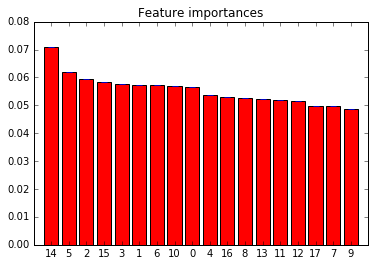

In [295]:
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()